In [14]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


sf_username = '*******'
sf_password = '********'
sf_account = '*********'
sf_warehouse = 'COMPUTE_WH'
sf_database = 'TESTDB'
sf_schema = 'CORE'

dbcon = snowflake.connector.connect(
    user=sf_username,
    password=sf_password,
    account=sf_account,
    warehouse=sf_warehouse,
    database=sf_database,
    schema=sf_schema
)

## Question 1:
#### How many subscribers are there for each channel?

,CHANNEL_NAME,Channel,Number of Subcribers
0,straitstimesonline,The Straits Times,590000
1,zaobaodotsg,zaobaosg,182000
2,TheBusinessTimes,The Business Times,27200
3,BeritaHarianSG1957,Berita Harian Singapura,5010
4,Tamil_Murasu,Tamil Murasu,4860


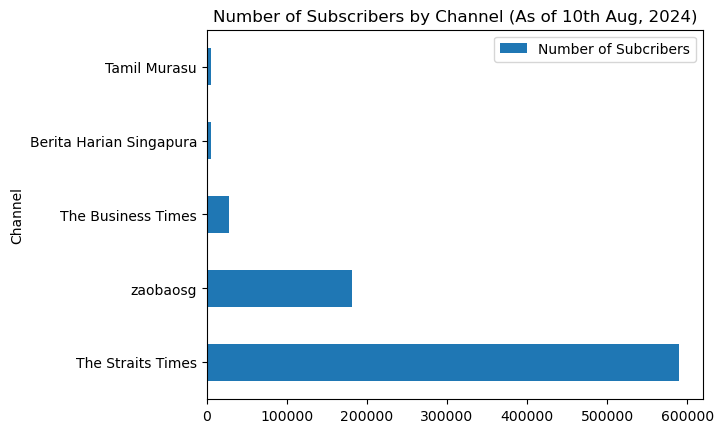

In [3]:
data = pd.read_sql("""select 
md.channel_name,
md.title as "Channel",
stat.subscriber_count as "Number of Subcribers" 
from CORE.tbl_yt_channel_stats stat
inner join CORE.tbl_yt_channel_md md on md.channel_id = stat.channel_id
where stat.rptg_dt='2024-08-10'
order by 3 desc;""",dbcon)
display(data)
data.plot(x='Channel',y=['Number of Subcribers'],kind='barh',title='Number of Subscribers by Channel (As of 10th Aug, 2024)')
plt.show()

## Question 2:
#### How many video’s have been published for each channel?

,CHANNEL_NAME,Channel,Number of Videos
0,straitstimesonline,The Straits Times,30446
1,zaobaodotsg,zaobaosg,5328
2,TheBusinessTimes,The Business Times,1270
3,Tamil_Murasu,Tamil Murasu,461
4,BeritaHarianSG1957,Berita Harian Singapura,452


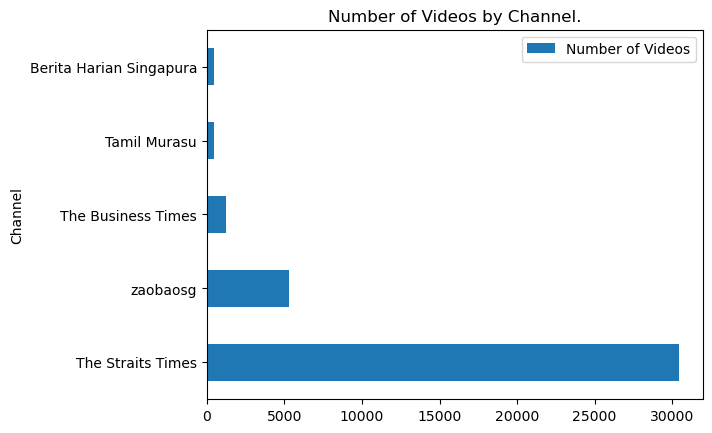

In [6]:
data = pd.read_sql("""select 
md.channel_name,
md.title as "Channel",
stat.video_count as "Number of Videos" 
from CORE.tbl_yt_channel_stats stat
inner join CORE.tbl_yt_channel_md md on md.channel_id = stat.channel_id
where stat.rptg_dt='2024-08-10'
order by 3 desc;""",dbcon)
display(data)
data.plot(x='Channel',y=['Number of Videos'],kind='barh',title='Number of Videos by Channel.')
plt.show()

## Question 3:
#### What is the trend for videos published by each channel over the last 12 months?

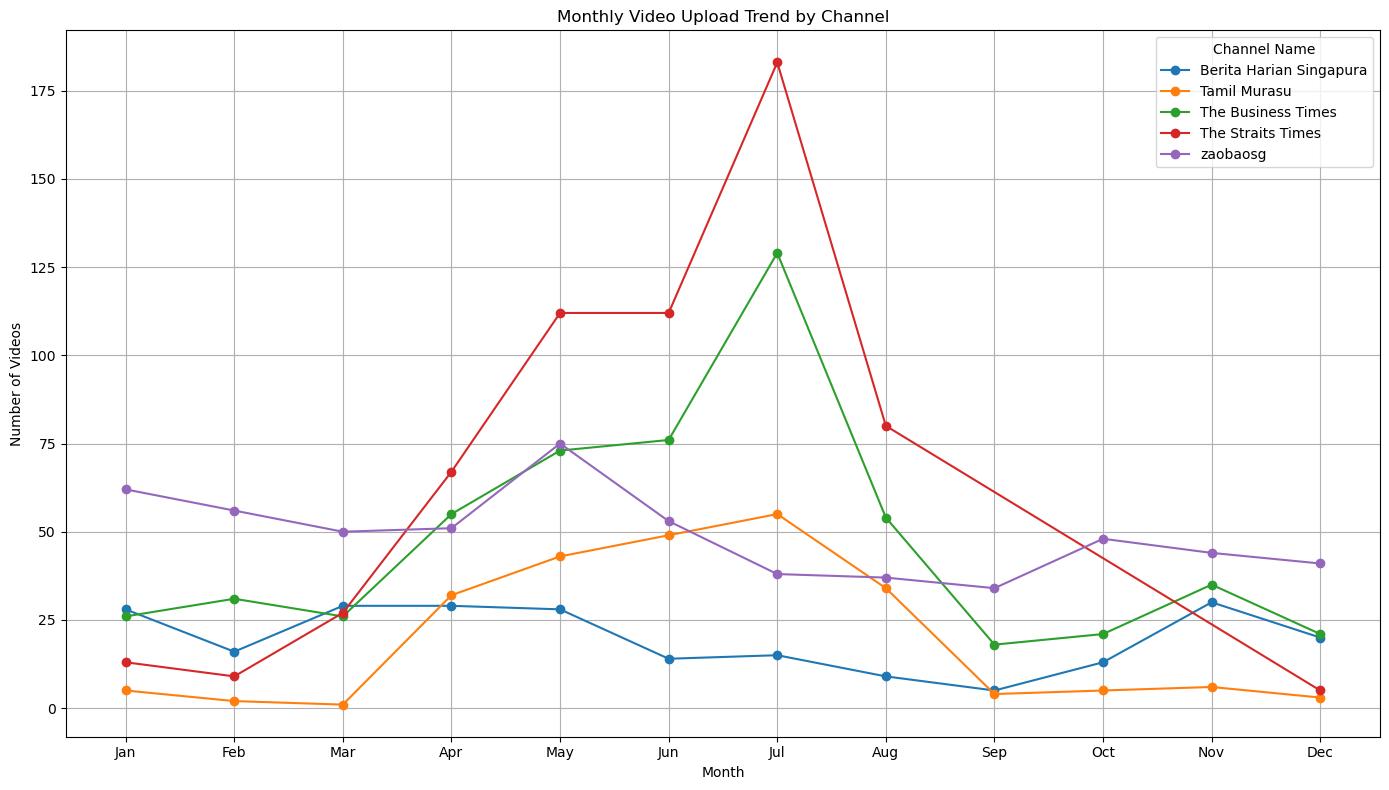

In [7]:
df = pd.read_sql("""SELECT 
    TO_CHAR(a.published_at, 'Mon') AS "Month",
    TO_CHAR(a.published_at, 'MM') AS "Month_num",
    chnl.title as "Channel Name",
    count(a.id) as "Number of videos"
FROM 
    CORE.tbl_yt_video_md a
    inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = a.channel_id
GROUP BY 1,2,3
order by 2,3;
""",dbcon)

# Convert Month_num to a categorical type with a specific order
df['Month_num'] = pd.Categorical(df['Month_num'], categories=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], ordered=True)
df = df.sort_values(by=['Channel Name', 'Month_num'])

# Plotting
plt.figure(figsize=(14, 8))

# Plot for each channel
for channel in df['Channel Name'].unique():
    channel_data = df[df['Channel Name'] == channel]
    plt.plot(channel_data['Month_num'], channel_data['Number of videos'], marker='o', label=channel)

plt.xlabel('Month')
plt.ylabel('Number of Videos')
plt.title('Monthly Video Upload Trend by Channel')
plt.xticks(ticks=df['Month_num'].unique(), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Channel Name')
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 4:
#### Which are the most viewed videos?
Below are the most viewed videos for each channel.

In [10]:
data = pd.read_sql("""select
chnl.title as "Channel Name",
vdo.title as "Video Title",
vdo.url as "URL",
vdo.published_at as "Published Date",
a.view_count as "Views"
from CORE.tbl_yt_video_stats a
inner join CORE.tbl_yt_video_md vdo on vdo.id = a.id
inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = a.channel_id
where a.rptg_dt = '2024-08-10'
qualify row_number() over(partition by a.channel_id order by a.view_count desc) = 1
order by 5 desc
""",dbcon)
display(data)

,Channel Name,Video Title,URL,Published Date,Views
0,The Business Times,"Chaos at Donald Trump rally, assassination att...",https://www.youtube.com/watch?v=q4Lftwq98DY,2024-07-14 04:40:47,1470189
1,zaobaosg,[ENG SUB] 朝鲜“新星女将军” 金正恩爱女的使命 Kim Jong Un’s Da...,https://www.youtube.com/watch?v=g_rn5Behgek,2024-01-19 07:00:15,1176936
2,The Straits Times,WATCH: The moment Trump was shot in right ear ...,https://www.youtube.com/watch?v=NsfMPTiIuvY,2024-07-13 23:51:25,632742
3,Berita Harian Singapura,Laporan Khas Berita Harian Singapura: Mengejar...,https://www.youtube.com/watch?v=9QOX5L27mBg,2024-07-27 21:30:22,51752
4,Tamil Murasu,லிட்டில் இந்தியா கலவரம் கற்றுத் தந்த பாடம். 10...,https://www.youtube.com/watch?v=YDrL8POdS0w,2023-12-08 07:31:31,2798


# Additional Observations
The below observations are only a few possible insights out of many.
Below are few extra KPI used to showcase additional insights.
   1. **Engagement Rate (Channel KPI)**: ((Total likes - Total dislikes + Comments)/Total views)*100
   2. **Growth Rate of Subscribers (Channel KPI)**: (Current Subscribers - Previous Subscribers) / Previous Subscribers * 100
   3. **Engagement Rate per Video (Video KPI)**: (Likes + Comments - Dislikes) / Views * 100

### Observation 1
Engagement Rate of each channel since last one year.

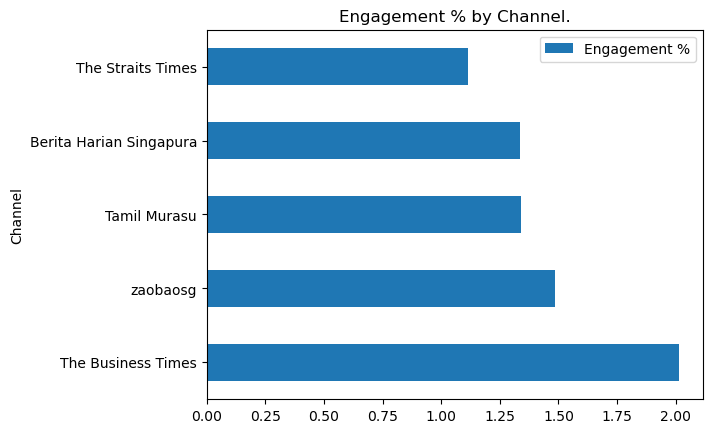

In [11]:
data = pd.read_sql("""select
chnl.title as "Channel",
sum(a.like_count) as total_likes,
sum(a.dislike_count) as total_dislikes,
sum(a.comment_count) as total_comment,
sum(a.view_count) as total_views,
((total_likes - total_dislikes + total_comment)/total_views)*100 as "Engagement %"
from
CORE.tbl_yt_video_stats a
inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = a.channel_id
where a.rptg_dt = '2024-08-10'
group by 1
order by 6 desc;""",dbcon)
#display(data)
data.plot(x='Channel',y=['Engagement %'],kind='barh',title='Engagement % by Channel.')
plt.show()

### Observation 2
Day over Day Growth Rate of Subscribers for each channel.

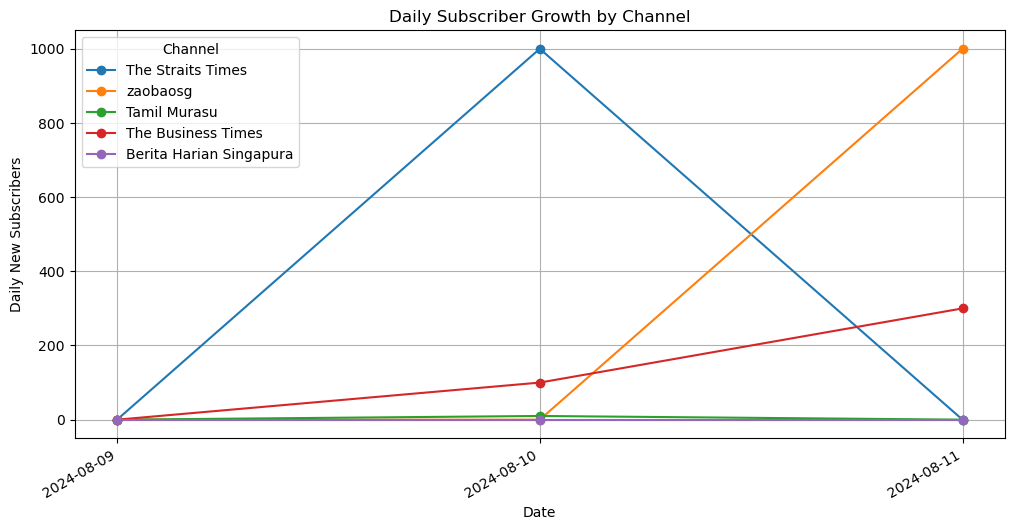

In [17]:
df = pd.read_sql("""select
orig.rptg_dt as "Date",
orig.channel_id,
md.title as "Channel",
coalesce((sum(orig.subscriber_count) - sum(prev.subscriber_count)),0) as "Daily new subscribers"
from
core.tbl_yt_channel_stats orig
left join core.tbl_yt_channel_stats prev on orig.channel_id = prev.channel_id and orig.rptg_dt = DATEADD(day, 1, prev.rptg_dt)
inner join core.tbl_yt_channel_md md on md.channel_id = orig.channel_id
group by 1,2,3
""",dbcon)
#display(data)

df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

# Sort the DataFrame by Date to ensure the X-axis is ordered
df = df.sort_values(by="Date")

# Create a plot with Date on X-axis and Daily new subscribers on Y-axis
plt.figure(figsize=(12, 6))

# Loop through the unique channels to plot each channel's data
for channel in df["Channel"].unique():
    channel_data = df[df["Channel"] == channel]
    plt.plot(channel_data["Date"], channel_data["Daily new subscribers"], marker='o', label=channel)

# Set X-axis format for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Daily New Subscribers")
plt.title("Daily Subscriber Growth by Channel")
plt.legend(title="Channel")
plt.grid(True)

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

### Observation 3
Top 3 most engaging videos of each channel.

In [4]:
data = pd.read_sql("""select
chnl.title as "Channel",
md.title as "Video Title",
md.url as "Video URL",
src.engagement_perc as "Engagement %",
src.engagement_rank as "Rank"
from
(select
id,
channel_id,
case when coalesce(view_count,0)>0 then ((like_count - dislike_count + comment_count)/view_count)*100 else 0 end as engagement_perc,
row_number() over(partition by channel_id order by engagement_perc desc) as engagement_rank
from 
CORE.tbl_yt_video_stats
where rptg_dt='2024-08-09'
qualify row_number() over(partition by channel_id order by engagement_perc desc) <= 3) src
inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = src.channel_id
inner join CORE.tbl_yt_video_md md on md.id = src.id
order by 1,5""",dbcon)
display(data)

,Channel,Video Title,Video URL,Engagement %,Rank
0,Berita Harian Singapura,Kaki Makan: Pemilik Waroeng Anak Indo dan Rumi...,https://www.youtube.com/watch?v=jvPDmuumxGM,10.2041,1
1,Berita Harian Singapura,Kaki Makan: Menu khas Ramadan terap budaya Tur...,https://www.youtube.com/watch?v=EktMlxqvuPA,9.0909,2
2,Berita Harian Singapura,Usaha gigih buah hasil walau galas pelbagai ta...,https://www.youtube.com/watch?v=zsvK6ay04Lo,7.6923,3
3,Tamil Murasu,முரசு காப்பிக் கடை: விலையேற்றத்திலும் குதூகலம்...,https://www.youtube.com/watch?v=LLTLJe5TH48,33.3333,1
4,Tamil Murasu,லாரன்ஸ் வோங் பிரதமராகவும் தர்மன் சண்முகரத்னம் ...,https://www.youtube.com/watch?v=s_Y3C-ILcNc,33.3333,2
5,Tamil Murasu,"100,000 எழுத்துருக்களால் ஆன தமிழரசனின் லீ குவா...",https://www.youtube.com/watch?v=heB5HI1gO70,11.3636,3
6,The Business Times,"Lens on Daily: Friday, July 26, 2024 (Ep 75)",https://www.youtube.com/watch?v=qeZyrQW9QXY,50.0000,1
7,The Business Times,"Lens on Daily: Friday, Jun 7, 2024 ( Ep 41)",https://www.youtube.com/watch?v=sfXnhbcAL1Q,12.5000,2
8,The Business Times,BT Future of Finance: How to take advantage of...,https://www.youtube.com/watch?v=BgRp6UBgLHs,11.1111,3
9,The Straits Times,K-pop stars Seventeen become Unesco ambassadors,https://www.youtube.com/watch?v=SiSbTCUp6XI,10.3064,1
